---
title: "[stock prediction] 3.1. 설명가능 AI (XAI), SHAP value"
author: "agsu"
date: "7/18/2022"
format: 
  html:
    code-fold: false
jupyter: python3
categories: [project, stock prediction]
image: ../image/stock6.png
---

# 3. 주가 상승 추세 패턴 검출   
## 3.1. 설명가능 AI (XAI), SHAP value 
이전 글 ( [[Stock Research] 2.3. CCI를 이용한 주가 데이터 필터링 ](https://ag-su.github.io/blog/posts/05.filtering.html)) 까지 데이터 전저리를 통해  baseline model에 비해 성능을 향상시킬 수 있었다. 이번 글에서는 `설명가능 AI` 기법중에서도 `SHAP value`가 무엇인지 알아보고, 앞서 학습했던 `CCI` 구간 별 `XGBoost` 모델을 사용하여 `SHAP value`를 계산함으로써 주가 이진분류 예측에 영향을 미친 중요 변수를 해석해 본다. 여기서 `summary plot`의 결과로 나온 상위 중요 변수로 데이터를 필터링하여 특정 집단을 구성하고, 공통된 특징이 있는지 확인한다. 


### 목차 
- (1) 설명가능 AI (XAI), SHAP value란? 
- (2) CCI 구간 별 summary plot 비교

---------

- 라이브러리 import  

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pymysql

import warnings
warnings.filterwarnings('ignore')

from ipywidgets import interact, interact_manual
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.offline as pyo
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (12,5)

import StockFunc as sf

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


<br>
<br>

## (1) 설명가능 AI (XAI), SHAP value란?

### 설명가능 AI (XAI,  Explainable Artificial Intelligence)
오늘날 인공지능의 성능이 좋아짐에 따라 모델의 복잡도 또한 높아지게 되었다. 여기서 예측 결과에 대한 모델의 신뢰성 문제가 따라오게된다. 설명가능 AI는 이러한 문제점을 해결하여 인공지능 알고리즘으로 작성된 결과와 출력을 인간인 사용자가 이해하고 신뢰할 수 있도록 해준다. 


본 프로젝트에서는 설명가능 AI 기법 중에서 `shap value`를 활용하여 변수 중요도를 파악하고, 변환된 SHAP 표준화 데이터셋을 이용한 연구를 진행한다. `SHAP(SHAPley Additional Descriptions)`는 모든 기계 학습 모델의 출력을 설명하기 위한 게임 이론적 접근법이다. 게임 이론의 고전적인 **shapley value**를 계산하여 입력 변수와 모델의 결과값 사이의 관계를 분석하는 XAI 기법 중 하나이다. 


***shapley value**  
-각 변수가 예측 결과물에 주는 **영향력의 크기**   
-해당 변수가 **어떤 영향**을 주는지 파악   
- (ex)  
    - 각 선수가 팀 성적에 주는 영향력 크기   
    - 해당 선수가 어떠한 영향을 주는가   
    - (선수 A가 있는 팀 B의 승률) - (선수 A가 없는 팀 B의 승률) = 7%     
       -> "선수 A는 팀 승률에 7% 만큼의 영향력이 있다."  



<br>

**[참고]**   
-[설명 가능한 AI](https://www.ibm.com/kr-ko/watson/explainable-ai)  
-[shap github](https://github.com/slundberg/shap#citations)  
-[A Unified Approach to Interpreting Model Predictions](https://arxiv.org/abs/1705.07874)

<br>
<br>

## (2) CCI 구간 별 summary plot 비교

- 데이터셋 불러오기 

In [2]:
#collapse-hide
import pickle
with open('dataset_cci_filtering.pickle', 'rb') as handle:
    dic_dataset_model = pickle.load(handle)

- 컬림 리스트 생성 

In [3]:
#collapse-hide
lst_col_info = []

lst_col = ['Open', 'High', 'Low', 'Close', 'trading_value', 'MA5', 'MA20', 'MA60', 'MA120', 
           'VMAP', 'BHB', 'BLB', 'KCH', 'KCL', 'KCM', 'DCH', 'DCL', 'DCM',
           'SMA', 'EMA', 'WMA', 'Ichimoku', 'Parabolic SAR', 'KAMA','MACD']   +  ['Change', 'Volume', 'MFI', 'ADI', 'OBV', 
                                                                                   'CMF', 'FI', 'EOM, EMV', 'VPT', 'NVI', 'ATR', 'UI',
                                                                                   'ADX', '-VI', '+VI', 'TRIX', 'MI', 'CCI', 'DPO', 'KST', 
                                                                                   'STC', 'RSI', 'SRSI', 'TSI', 'UO', 'SR',
                                                                                   'WR', 'AO', 'ROC', 'PPO', 'PVO'] 
           

for day in range(9, -1, -1): 
    for col in lst_col: 
        lst_col_info.append(f'D-{day}_{col}')

<br>

### 1) 중립구간 CCI : (-20, 20)

- 중립구간 데이터셋 불러오기 

In [4]:
trainX_1, trainY_1, testX_1, testY_1, lst_code_date_1, lst_code_date_test_1, xgb_1 = dic_dataset_model['CCI -20~20']
print('train dataset: ', trainX_1.shape, trainY_1.shape)
print('test dataset: ', testX_1.shape, testY_1.shape)

train dataset:  (123321, 560) (123321,)
test dataset:  (36885, 560) (36885,)


- numpy -> DataFrame 

In [5]:
##### train
df_trainX_1 = pd.DataFrame(trainX_1)
df_trainX_1.columns = lst_col_info
df_trainY_1 = pd.DataFrame(trainY_1)

##### test 
df_testX_1 = pd.DataFrame(testX_1)
df_testX_1.columns = lst_col_info
df_testY_1 = pd.DataFrame(testY_1)

df_trainX_1.head()

,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_trading_value,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,...,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
0,1.005714,1.048000,1.000000,1.040000,462369.440000,0.994514,0.968971,0.981010,1.040524,0.993304,...,52.767201,0.057077,20.137832,43.856662,46.236559,-53.763441,433.235294,2.564103,1.624561,-3.039166
1,1.000000,1.011236,0.974157,0.988764,94755.235955,1.004719,0.987640,0.954307,1.015178,1.002500,...,58.029378,0.779487,6.199506,48.326356,75.903614,-24.096386,53.588235,-0.885936,0.530558,2.429462
2,1.007463,1.012793,0.996802,1.005330,105709.495736,0.974840,0.944350,0.910856,0.953198,0.950598,...,46.479620,0.000000,16.267954,46.534386,14.444444,-85.555556,343.500000,0.898876,1.645809,10.986297
3,1.007423,1.033934,0.975610,1.033934,327239.156946,0.987063,0.943160,0.907971,0.948206,0.958880,...,52.721907,0.225976,14.411703,44.991463,40.909091,-59.090909,289.705882,1.651982,1.484638,9.126668
4,0.994872,0.994872,0.950769,0.974359,168981.128205,0.966974,0.914769,0.879402,0.917145,0.932738,...,49.489503,0.108960,11.827189,44.008782,26.136364,-73.863636,221.794118,-2.985075,1.229302,5.503306


- SHAP 표준화 

In [6]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_1)
shap_values_1 = explainer.shap_values(df_trainX_1) # train 
shap_values_test_1 = explainer.shap_values(df_testX_1) # test 

#### Train dataset Summary plot

- summary plot 해석 방법   

`Summary plot`에서 `X축`은 SHAP 값으로, 모델 예측 값에 영향을 준 정도의 수치를 의미한다. (-1, 1) 사이의 값이며 영향력이 없을 수록 0에 가까운 값이다. 이러한 SHAP value가 양수 값이면 긍정적인 영향 (양의 영향), 음수 값이면 부정적인 영향 (음의 영향)을 끼쳤음을 뜻한다. 해당 모델에서는 양수의 값이 클 수록 label 1로 예측하는 데 영향을 많이 미쳤다는 뜻으로 해석할 수 있다. `Y축`은 설명 변수이고, `색깔`은 설명 변수의 개별 데이터 값의 크기를 말한다. 빨간색일 수록 데이터의 값이 상대적으로 크고, 파란색일 수록 값이 상대적으로 작은 데이터임을 뜻한다. 

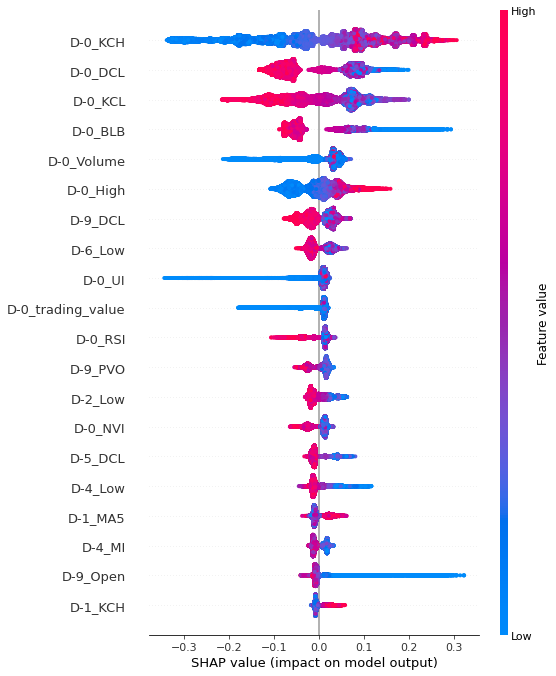

In [7]:
shap.summary_plot(shap_values_1, df_trainX_1)

#### Test dataset summary plot 

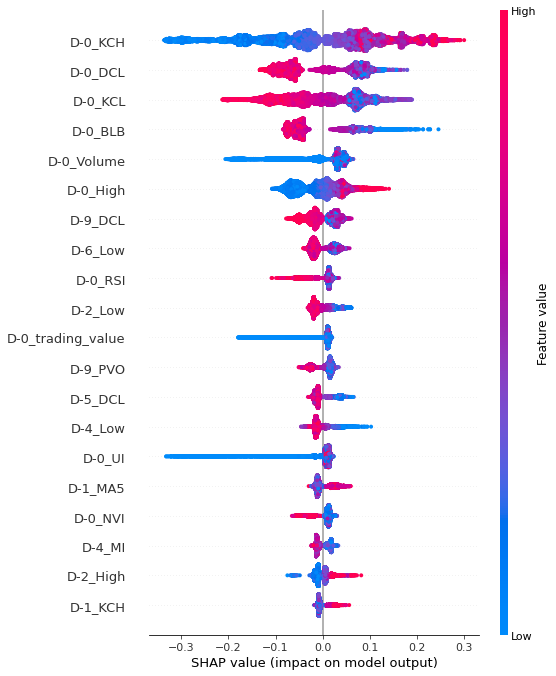

In [8]:
shap.summary_plot(shap_values_test_1, df_testX_1)

`중립구간`에서 train, test 데이터셋의 중요 변수 상위 6개가 동일하게 나왔음을 알 수 있다. 
중요도 상위 설명 변수 3개를 해석해보면, **D-0_KCH**의 값이 클 수록 양의 영향 (다음 날 종가 2% 상승할 것이라 예측하는 데 영향)을 미쳤으며, **D-0_DCL** 의 값이 작을 수록 양의 영향, **D-0_KCL**의 값이 작을 수록 양의 영향을 끼쳤다. 

<br>

### 2) 과열구간/과매수구간 CCI : (100, $\infty$)

- 과매수구간 데이터셋 불러오기 

In [9]:
trainX_2, trainY_2, testX_2, testY_2, lst_code_date_2, lst_code_date_test_2, xgb_2 = dic_dataset_model['CCI 100~']
print('train dataset: ', trainX_2.shape, trainY_2.shape)
print('test dataset: ', testX_2.shape, testY_2.shape)

train dataset:  (256399, 560) (256399,)
test dataset:  (64768, 560) (64768,)


- numpy -> DataFrame

In [10]:
##### train
df_trainX_2 = pd.DataFrame(trainX_2)
df_trainX_2.columns = lst_col_info
df_trainY_2 = pd.DataFrame(trainY_2)

##### test 
df_testX_2 = pd.DataFrame(testX_2)
df_testX_2.columns = lst_col_info
df_testY_2 = pd.DataFrame(testY_2)

df_trainX_2.head()

,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_trading_value,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,...,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
0,1.014235,1.014235,0.990510,1.002372,50865.391459,1.012100,1.039442,1.004251,1.067230,1.062162,...,67.826155,1.000000,14.884190,55.338001,100.952381,0.952381,223.411765,10.613208,1.337481,6.227088
1,0.984615,1.023669,0.984615,0.997633,55152.152663,1.000947,1.036391,1.002367,1.063619,1.055599,...,68.784853,1.000000,18.642720,51.178165,94.067797,-5.932203,310.029412,10.941176,1.688808,4.010564
2,0.990510,1.064057,0.990510,1.026097,78619.572954,1.007355,1.039739,1.005575,1.065055,1.054236,...,74.103331,1.000000,23.963771,66.127796,100.000000,-0.000000,393.558824,15.658363,2.221982,14.120940
3,0.996532,1.040462,0.996532,1.038150,210838.980347,0.992832,1.016358,0.980732,1.037177,1.021560,...,64.812483,0.721663,25.077575,61.734791,82.517483,-17.482517,451.588235,12.426036,2.389092,13.705978
4,1.013363,1.013363,0.982183,0.983296,303571.073497,0.965256,0.980401,0.944933,0.998181,0.984157,...,66.615529,0.774168,26.576492,63.519219,89.510490,-10.489510,525.558824,13.879004,2.576580,18.168169


- SHAP 표준화 

In [11]:
##### train
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_2)
shap_values_2 = explainer.shap_values(df_trainX_2)
shap_values_test_2 = explainer.shap_values(df_testX_2)

#### Train dataset Summary plot

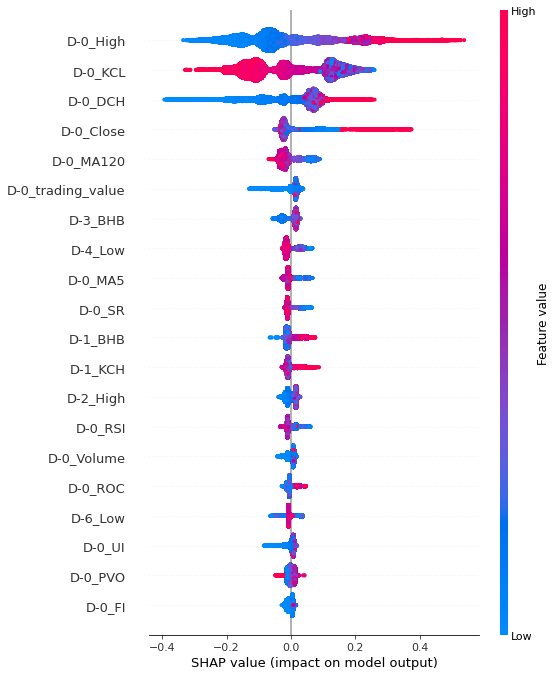

In [12]:
shap.summary_plot(shap_values_2, df_trainX_2)

#### Test dataset Summary plot

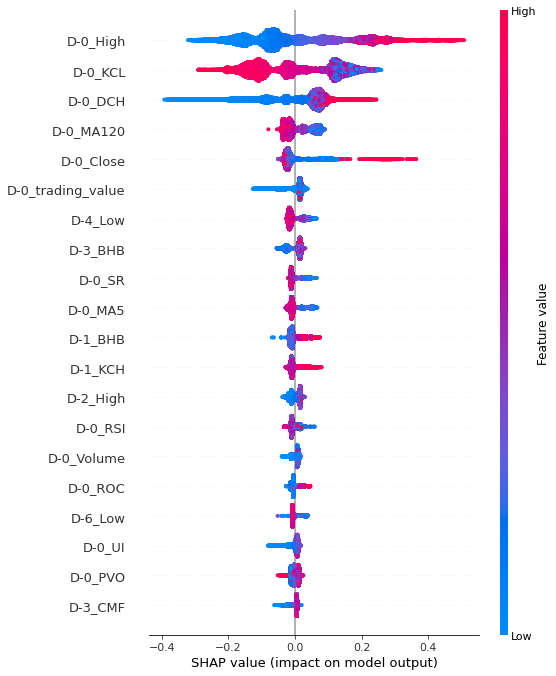

In [13]:
shap.summary_plot(shap_values_test_2, df_testX_2)

`과매수구간`도 마찬가지로 train, test 데이터셋은 유사한 변수 중요도를 가진다. **D-0_High**의 값이 클 수록, **D-0_KCL**의 값이 작을 수록, **D-0_DCH** 값이 클 수록 양의 영향을 미쳤다고 해석된다. 

<br>

### 3) 침체구간/과매도구간 CCI : (-$\infty$, -100)

- 과매수구간 데이터셋 불러오기 

In [4]:
trainX_3, trainY_3, testX_3, testY_3, lst_code_date_3, lst_code_date_test_3, xgb_3 = dic_dataset_model['CCI ~-100']
print('train dataset: ', trainX_3.shape, trainY_3.shape)
print('test dataset: ', testX_3.shape, testY_3.shape)

train dataset:  (269977, 560) (269977,)
test dataset:  (73435, 560) (73435,)


- numpy -> DataFrame

In [5]:
##### train
df_trainX_3 = pd.DataFrame(trainX_3)
df_trainX_3.columns = lst_col_info
df_trainY_3 = pd.DataFrame(trainY_3)

##### test 
df_testX_3 = pd.DataFrame(testX_3)
df_testX_3.columns = lst_col_info
df_testY_3 = pd.DataFrame(testY_3)

df_trainX_3.head()

,D-9_Open,D-9_High,D-9_Low,D-9_Close,D-9_trading_value,D-9_MA5,D-9_MA20,D-9_MA60,D-9_MA120,D-9_VMAP,...,D-0_RSI,D-0_SRSI,D-0_TSI,D-0_UO,D-0_SR,D-0_WR,D-0_AO,D-0_ROC,D-0_PPO,D-0_PVO
0,0.991238,1.004381,0.971522,0.980285,140309.140197,0.984885,0.943045,0.936528,0.995007,0.969697,...,40.723504,0.000000,5.486901,35.175106,8.421053,-91.578947,86.911765,-7.362637,0.401602,-13.360869
1,1.019084,1.019084,0.938931,0.946565,690931.786260,0.964885,0.889427,0.787226,0.717487,0.930415,...,45.121178,0.022302,7.541308,40.870588,10.000000,-90.000000,43.235294,-13.127413,1.251577,-3.674717
2,0.991935,1.040323,0.987903,1.004032,317878.620968,1.026613,0.945484,0.836371,0.760813,0.987418,...,42.403451,0.000000,3.945359,39.056401,1.960784,-98.039216,-168.382353,-13.725490,0.615608,-4.840261
3,1.000000,1.020080,0.979920,0.991968,350971.128514,1.012851,0.946787,0.837590,0.760281,0.986872,...,36.691473,0.000000,-1.153744,34.272840,0.000000,-100.000000,-473.676471,-20.610687,-0.308624,-0.268302
4,1.004049,1.004049,0.955466,0.979757,327074.267206,1.010526,0.958907,0.848691,0.768900,1.001767,...,38.186006,0.041239,-4.753380,32.124091,4.761905,-95.238095,-627.794118,-15.322581,-0.969999,0.192505


- SHAP 표준화 

In [6]:
##### train
import shap
shap.initjs()
explainer = shap.TreeExplainer(xgb_3)
shap_values_3 = explainer.shap_values(df_trainX_3)
shap_values_test_3 = explainer.shap_values(df_testX_3)

#### Train dataset Summary plot

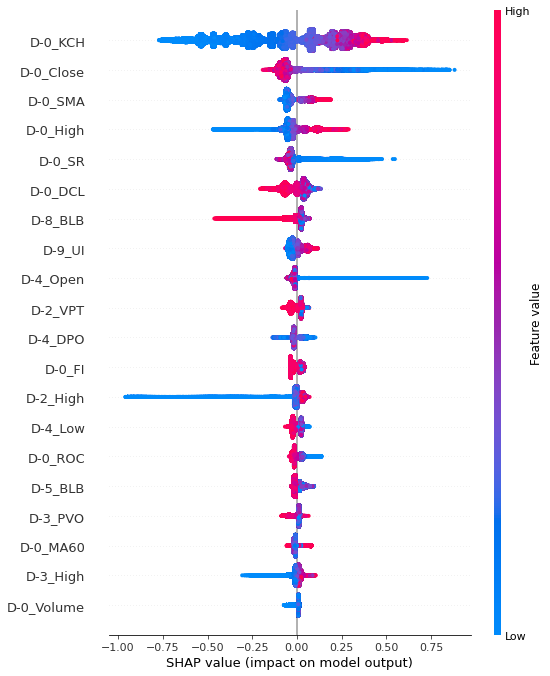

In [10]:
shap.summary_plot(shap_values_3, df_trainX_3)

#### Test dataset Summary plot

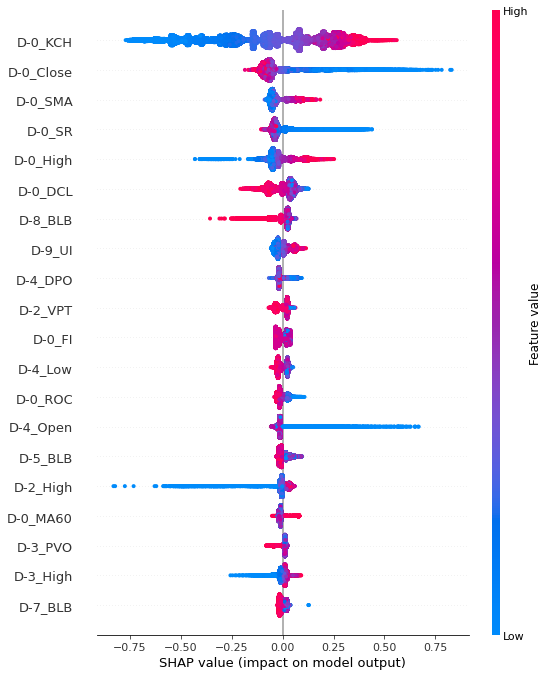

In [11]:
shap.summary_plot(shap_values_test_3, df_testX_3)

`과매도구간` 또한 train, test 데이터셋이 유사한 변수 중요도를 가졌다. `과매도구간`은 모델 학습 당시 모델의 성능이 가장 좋게 나왔으며, `summary plot` 에서도 색깔의 경계가 가장 뚜렷하게 나타났다. **D-0_KCH**의 값이 클 수록, **D-0_Close**의 값이 작을 수록, **D-0_SMA** 값이 클 수록 양의 영향을 미쳤다고 해석할 수 있다. 

<br>
<br>

### 상위 변수 3개로 필터링 한 데이터
색의 경계가 가장 뚜렷하게 나타난 `과매도 구간`에서 상위 변수 3개를 이용하여 데이터를 필터링 하고, 특징이 나타나는지 확인해본다. 

In [19]:
df_testX_3['Code'] = lst_code_date_test_3[:, 0]
df_testX_3['Date'] = lst_code_date_test_3[:, 1]

df_shap_test_3 = pd.DataFrame(shap_values_test_3, columns=lst_col_info)

condition1 = df_shap_test_3['D-0_KCH'] > 0.3
condition2 = df_shap_test_3['D-0_Close'] > 0
condition3 = df_shap_test_3['D-0_SMA'] > 0.05

print('조건을 만족하는 데이터의 개수:', len(df_testX_3.loc[condition1 & condition2 & condition3]))
print()
print("<빈도수 상위 날짜 Top 5>")
display(df_testX_3.loc[condition1 & condition2 & condition3, ['Date']].value_counts().head())

조건을 만족하는 데이터의 개수: 467

<빈도수 상위 날짜 Top 5>


Date      
2021-10-06    58
2021-08-20    45
2021-03-10    16
2021-10-01    13
2021-10-05    13
dtype: int64

조건을 만족하는 데이터 467개 중 빈도수가 높게 나오는 날짜들이 있다. 2021년 10월 6일, 2021년 8월 20일의 데이터를 살펴보도록 한다. 이 때 종목코드는 `sample` 함수를 사용하여 랜덤으로 선정한다.

- 조건을 만족하는 데이터 중 상위 빈도수 날짜의 랜덤 종목 차트 확인 

In [21]:
df_1006 = df_testX_3.loc[condition1 & condition2 & condition3 & (df_testX_3['Date'] == '2021-10-06'), ['Date', 'Code']].sample(5).reset_index(drop=True)
df_0820 = df_testX_3.loc[condition1 & condition2 & condition3 & (df_testX_3['Date'] == '2021-08-20'), ['Date', 'Code']].sample(5).reset_index(drop=True)

pd.concat([df_1006, df_0820], axis=1)

,Date,Code,Date,Code
0,2021-10-06,154040,2021-08-20,003830
1,2021-10-06,092070,2021-08-20,103590
2,2021-10-06,101390,2021-08-20,043340
3,2021-10-06,057030,2021-08-20,039610
4,2021-10-06,084870,2021-08-20,025620


**2021년 10월 6일**  
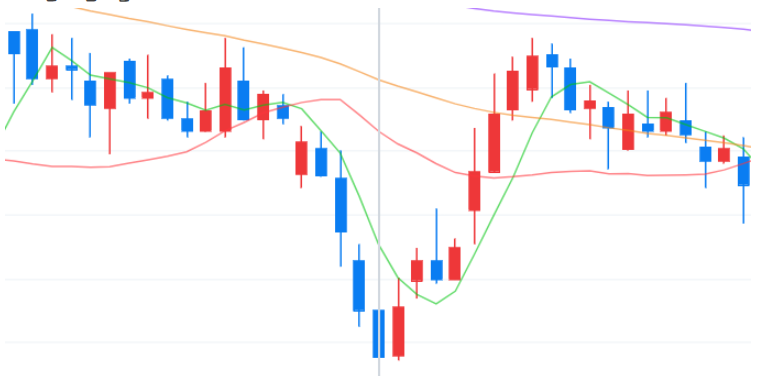  
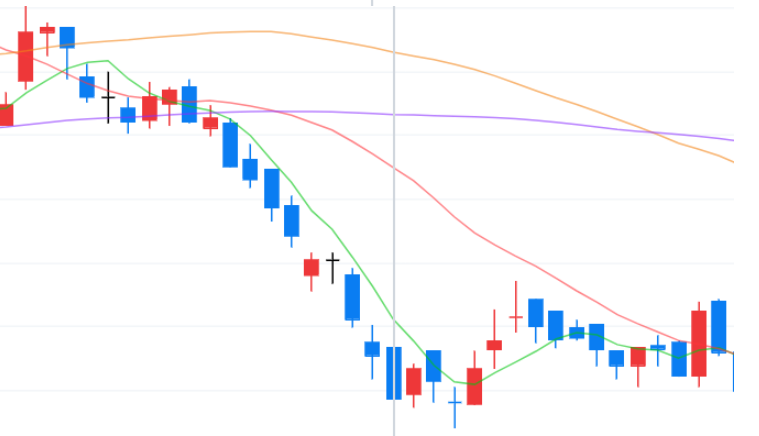  
"종목코드: 154040, 092070"

**2021년 8월 20일**  
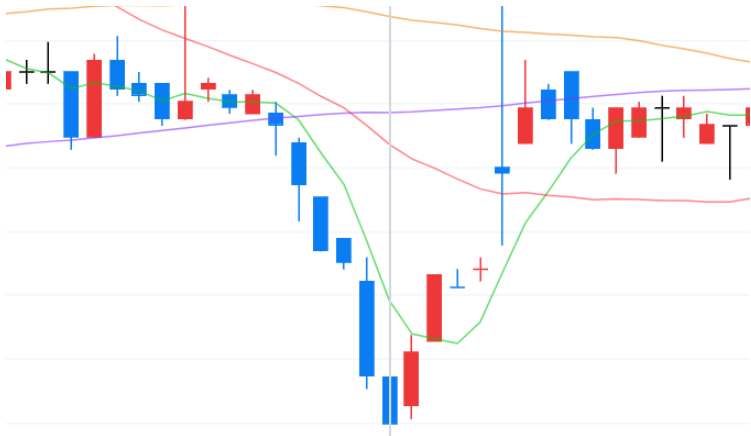
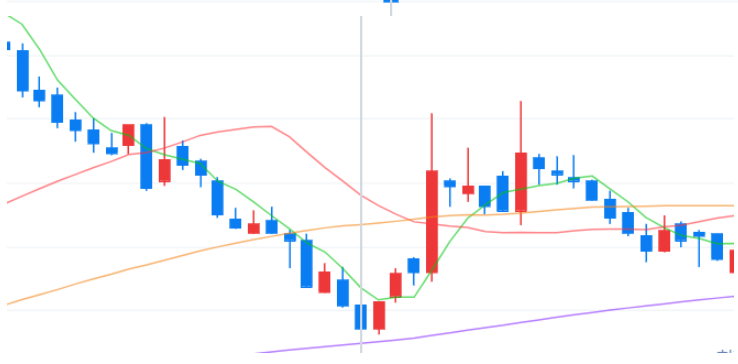  
"종목코드: 003830, 103590"

이미지 출처-Naver 증권

<br>

랜덤으로 선택한 4가지 종목들의 차트를 확인해 보았을 때, 하락을 종료하고 상승의 초입 부분에서 매매 시그널을 보였다.  

- SHAP 표준화 데이터셋 저장 

In [ ]:
#collapse-hide
import pickle 
dic_shap_dataset = {'CCI -20~20': [shap_values_1, shap_values_test_1],
                'CCI 100~': [shap_values_2, shap_values_test_2],
                'CCI ~-100': [shap_values_3, shap_values_test_3]}

with open('shap_dataset_cci_filtering.pickle', 'wb') as handle:
    pickle.dump(dic_shap_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

<br>
<br>

본 프로젝트 방향은 `SHAP`을 활용하여 **유사한 특징을 갖고 있는 특정 집단을 발견하고 해석해내는 것**이라고 할 수 있다. 위에서 변수 중요도를 시각화 하고, 상위 3개 변수에 대하여 양의 영향을 미치는 비슷한 크기의 값인 데이터들만 필터링하여 차트를 확인하였다. 이번 글에서 `SHAP value summary plot`을 활용하여 직접 집단을 구성해보았다면, 다음에는 이러한 집단을 알고리즘을 사용하여, 구체적으로 형성하는 방법을 연구한다. 다음 글에서는 저장한 SHAP 표준화 데이터셋과 주가 데이터셋을 2차원 평면에 시각화 하여 **군집**들이 형성되는지 확인하는 시간을 가진다. 